In [1]:
import numpy as np
import cv2

In [2]:
from matplotlib import pyplot as plt

## Question 2 - Finding background pixels of an image

In [3]:
import numpy as np

In [4]:
def get_neighbors(position, image, is_4_connected=True):
    y, x = position
    neighbors = []
    top_condition = y - 1 >= 0
    bottom_condition = y + 1 < image.shape[0]
    right_condition = x + 1 < image.shape[1]
    left_condition = x - 1 >= 0
    
    if bottom_condition and image[y+1, x] == image[y, x]:
        neighbors.append((y+1, x))
    if top_condition and image[y-1, x] == image[y, x]:
        neighbors.append((y-1, x))
    if right_condition and image[y, x+1] == image[y, x]:
        neighbors.append((y, x+1))
    if left_condition and image[y, x-1] == image[y, x]:
        neighbors.append((y, x-1))
    
    if not is_4_connected:
        # check diagonals
        if top_condition:
            if right_condition:
                neighbors.append((y-1, x+1))
            elif left_condition:
                neighbors.append((y-1, x-1))
        if bottom_condition:
            if right_condition:
                neighbors.append((y+1, x+1))
            elif left_condition:
                neighbors.append((y+1, x-1))

    return neighbors

In [5]:
# regular dfs - neighbors are defined as 4-connected by default
def dfs(image, vertex_position, visited, connectivity_component_num, labels, is_4_connected):
    y, x = vertex_position
    visited[y, x] = True
    neighbors = get_neighbors(vertex_position, image, is_4_connected)
    for neighbor in neighbors:
        neighbor_y, neighbor_x = neighbor
        if not visited[neighbor_y, neighbor_x]:
            dfs(image, neighbor, visited, connectivity_component_num, labels, is_4_connected)
    
    labels[y, x] = connectivity_component_num

In [6]:
def label_components(image, is_4_connected=True):
    labels = np.zeros_like(image).astype(np.int32)
    visited = np.zeros_like(labels) != 0
    connectivity_component_num = 1

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y, x] >= 1:
                visited[y, x] = True
                continue
            if not visited[y, x]:
                dfs(image, (y, x), visited, connectivity_component_num, labels, is_4_connected)
                connectivity_component_num += 1
    return connectivity_component_num - 1, labels

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def get_background_pixels(image, is_4_connected=True, plot=True):
    _, labels = label_components(image, is_4_connected)
    
    num_of_objects = labels.max()
    # isolating each object in it's own image
    object_heatmaps = np.zeros((num_of_objects, image.shape[0], image.shape[1]))
    # 
    complementary_binary_images = np.zeros((num_of_objects, image.shape[0], image.shape[1]))
    for label in range(1, num_of_objects):
        label_mask = labels == label
        object_heatmaps[label] = (label_mask * (labels - labels + 1)).astype(np.uint32)
        complementary_binary_images[label] = np.abs(1 - object_heatmaps[label])
        complementary_num_of_connectivity_components, complementary_labels = label_components(object_heatmaps[label])
        # if we found more than 1 connectivity component it means the components that are larger than 1 are its' holes, as we've reached the component itself first
        # so we'll label all those pixels with the corresponding label
        if complementary_num_of_connectivity_components > 1:
            labels[np.where(complementary_labels >= 2)] = label

    # Background pixels are the ones with the label of 0
    background_pixels = np.where(labels == 0)

    if plot:
        # background pixels marked with 0 (right) from the original image (left)
        # objects in the original image are labeled accordingly, with their holes
        _, axes = plt.subplots(1, 2, figsize=(16, 16))
        axes[0].imshow(image, cmap='gray')
        sns.heatmap(labels, ax=axes[1], annot=True, annot_kws={'fontsize': 8}, square=True, cbar=False)
        plt.show()

    return background_pixels, labels

#### Example

In [9]:
mean = 0
std = 5
m, n = 32, 32

binary_image = (np.random.normal(loc=mean, scale=std, size=(m, n)) > 0).astype(np.uint8)

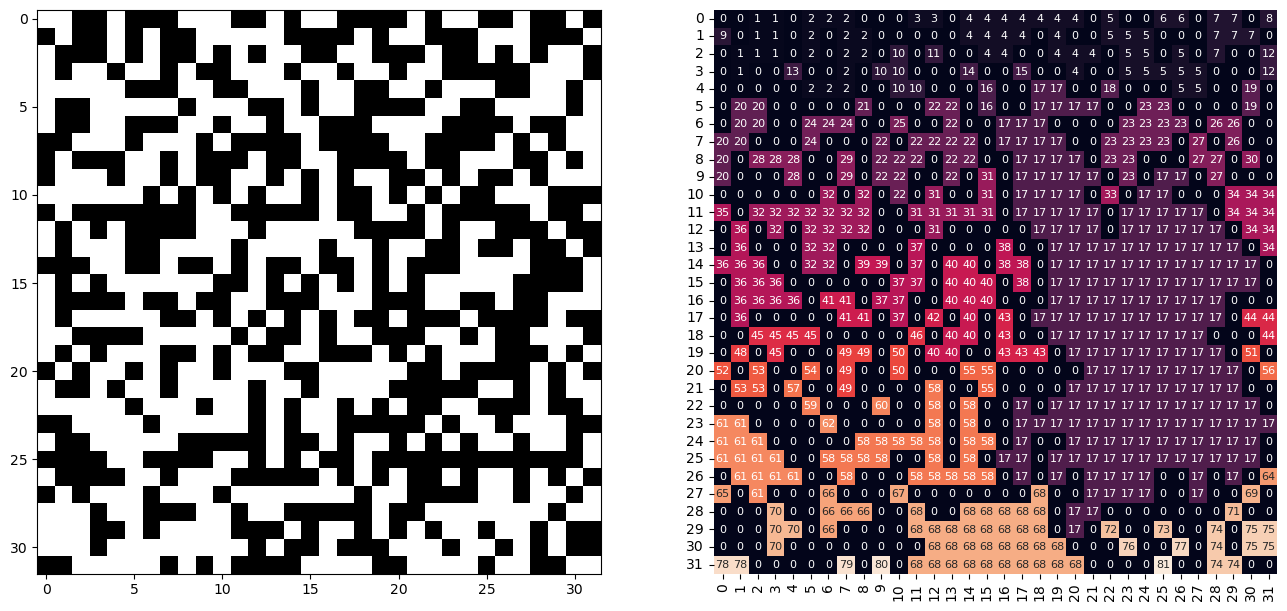

In [10]:
_, _ = get_background_pixels(binary_image, is_4_connected=True)

## Question 3

In [11]:
# note: make sure to pass an RGB image and not BGR
def H_func(image, epsilon=1e-8):
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]

    # getting theta values per pixel
    numerator = 0.5 * (R - G + R - B)
    denominator = np.sqrt((R - G) ** 2 + (R - B) * (G - B)) + epsilon
    theta = np.arccos(numerator / denominator)
    
    new_pixel_values = np.where(B <= G, theta, 360 - theta) / 360
    return new_pixel_values

def S_func(image, epsilon=1e-8):
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    return 1 - (3 / (R + G + B + epsilon)) * np.min(image, axis=2)

def I_func(image):
    return np.mean(image, axis=2)  # averaging RGB values

In [12]:
image_file_path = './lena.jpg'

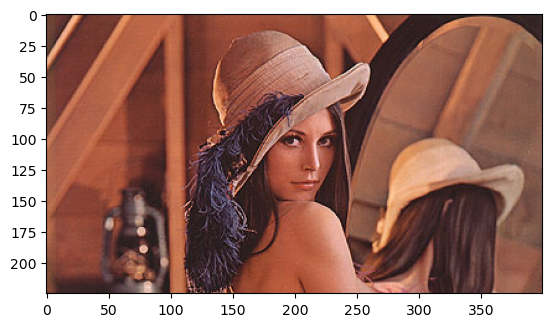

In [13]:
# cv2 reads in BGR format so we're reversing the channels to be RGB
img = cv2.imread(image_file_path)[..., ::-1] / 255
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow((img * 255).astype(np.uint8))

In [14]:
H = H_func(img)
S = S_func(img)
I = I_func(img)
# add all channels together
new_img = np.stack([H, S, I], axis=-1)

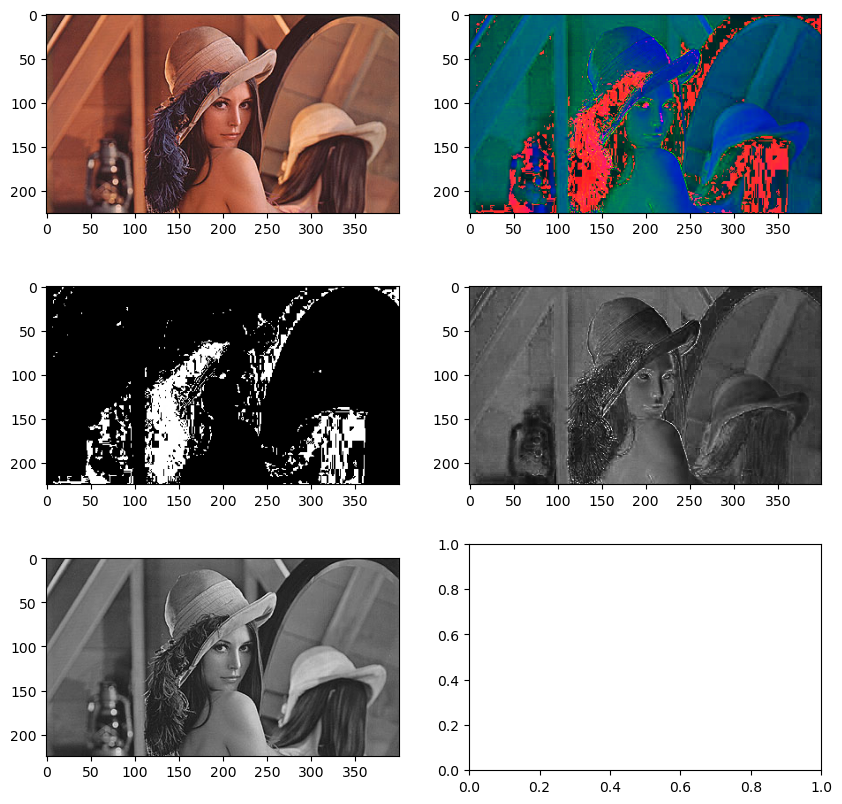

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes[0, 0].imshow(img)
axes[0, 1].imshow(new_img)
axes[1, 0].imshow(H, cmap='gray')
axes[1, 1].imshow(S, cmap='gray')
axes[2, 0].imshow(I, cmap='gray')

## Question 4

In [16]:
floyd_steinberg_kernel = np.array([[
    [0, 0, 0],
    [0, 0, 7/16],
    [3/16, 5/16, 1/16]
]])

In [17]:
def get_closest_vector(vector, channel_vectors):
    distances = distances = np.sqrt(np.square(vector - channel_vectors).sum(axis=1))
    return channel_vectors[np.argmin(distances)]

In [18]:
# will be used for easier usage in the kernel multiplication
def symmetric_padding(image, pad_value=0):
    height, width, n_channels = image.shape
    # padded image will have 2 more rows and columns for each color channel
    padded_image = np.zeros((height + 2, width + 2, n_channels))
    # padding 2D tensors from right & left and from top & bottom
    for c in range(n_channels):
        padded_image[..., c] = np.pad(image[..., c], 1, mode='constant', constant_values=pad_value)
    return padded_image

In [19]:
def floyd_steinberg_on_pixel(original_pixel_coordinates, closest_pixel, padded_image, dithered_image):
    h, w = original_pixel_coordinates
    padded_h, padded_w = h+1, w+1
    # if values in the vector are larger/equal than 128 set it to 255, else set to 0
    dithered_image[h, w, :] = 255 * (dithered_image[h, w, :] >= 128)
    # calculate diff with the "original" image which is the padded image
    diff = padded_image[padded_h-1:padded_h+2, padded_w-1:padded_w+2, :] - closest_pixel
    # update the dithered image with the delta across all channels
    dithered_image[padded_h-1:padded_h+2, padded_w-1:padded_w+2, :] += diff * floyd_steinberg_kernel

In [20]:
def custom_error_diffusion(image, channel_vectors):
    if len(channel_vectors) == 0:
        raise Exception("channel_vectors can't be empty!")
    
    final_image = np.empty_like(image)
    # padding the original image with zeros along the width and height axes (not color channels) for faster usage of kernel multiplication
    padded_image = symmetric_padding(image=image, pad_value=0) # symmetric_padding(image=image, target_shape=(image.shape[0]+2, image.shape[1]+2, image.shape[2]), pad_value=0)
    dithered_image = padded_image.copy()

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel = image[y, x]
            closest_vector = get_closest_vector(pixel, channel_vectors)
            # set closest vector in final_image as-is
            final_image[y, x] = closest_vector
            # execute error diffusion on dithered_image on that pixel
            floyd_steinberg_on_pixel((y, x), closest_vector, padded_image, dithered_image)

    return final_image

In [21]:
r = np.array([255, 0, 0])
g = np.array([0, 255, 0])
b = np.array([0, 0, 255])
channel_vectors = np.array([r, g, b])

In [61]:
vectors = np.random.randn(3, 3)

In [62]:
result_image = custom_error_diffusion(img, vectors)

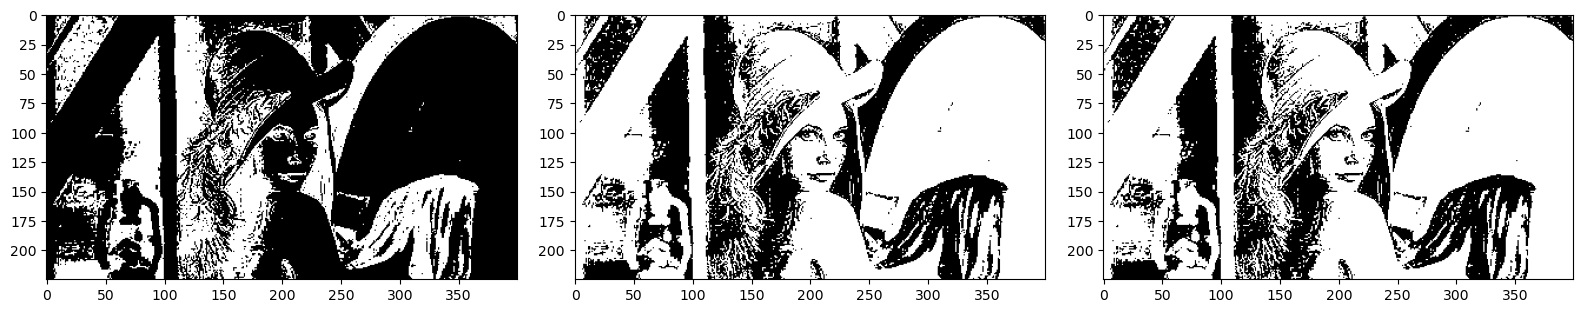

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
fig.tight_layout()

for i in range(result_image.shape[-1]):
    axes[i].imshow(result_image[..., i], cmap='gray')

In [64]:
result_image = custom_error_diffusion(img, channel_vectors)

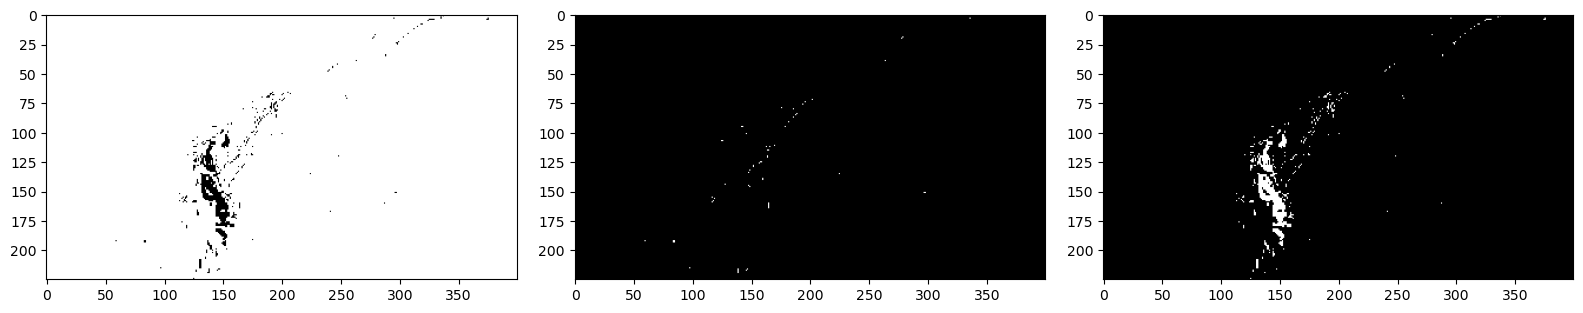

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
fig.tight_layout()

for i in range(result_image.shape[-1]):
    axes[i].imshow(result_image[..., i], cmap='gray')